In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

In [2]:
class CFG:    
    # config
    WORK_DIR = '../input/cassava-leaf-disease-classification'
    BATCH_SIZE = 8
    EPOCHS = 5
    TARGET_SIZE = 512

# Functions

In [3]:
def create_model():
    conv_base = EfficientNetB0(include_top = False, weights = None,
                               input_shape = (CFG.TARGET_SIZE, CFG.TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [4]:
def activation_layer_vis(img, activation_layer = 0, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    rows = int(activations[activation_layer].shape[3] / 3)
    cols = int(activations[activation_layer].shape[3] / rows)
    fig, axes = plt.subplots(rows, cols, figsize = (15, 15 * cols))
    axes = axes.flatten()
    
    for i, ax in zip(range(activations[activation_layer].shape[3]), axes):
        ax.matshow(activations[activation_layer][0, :, :, i], cmap = 'viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
def all_activations_vis(img, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    layer_names = []
    for layer in model.layers[:layers]: 
        layer_names.append(layer.name) 

    images_per_row = 3
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1] 

        size = layer_activation.shape[1] 

        n_cols = n_features // images_per_row 
        display_grid = np.zeros((size * n_cols, images_per_row * size)) 

        for col in range(n_cols): 
            for row in range(images_per_row): 
                channel_image = layer_activation[0, :, :, col * images_per_row + row] 
                channel_image -= channel_image.mean() 
                channel_image /= channel_image.std() 
                channel_image *= 64 
                channel_image += 128 
                channel_image = np.clip(channel_image, 0, 255).astype('uint8') 
                display_grid[col * size : (col + 1) * size, 
                             row * size : (row + 1) * size] = channel_image 
        scale = 1. / size 
        plt.figure(figsize=(scale * 5 * display_grid.shape[1], 
                            scale * 5 * display_grid.shape[0])) 
        plt.title(layer_name) 
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

# Data

In [6]:
train_labels = pd.read_csv(os.path.join(CFG.WORK_DIR, "train.csv"))

STEPS_PER_EPOCH = len(train_labels)*0.8 / CFG.BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / CFG.BATCH_SIZE

    
train_labels.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

### ImageDataGenerator

In [7]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2, preprocessing_function = None,
                                     rotation_range = 45, zoom_range = 0.2,
                                     horizontal_flip = True, vertical_flip = True,
                                     fill_mode = 'nearest', shear_range = 0.1,
                                     height_shift_range = 0.1, width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels, directory = os.path.join(CFG.WORK_DIR, "train_images"),
                         subset = "training", x_col = "image_id",
                         y_col = "label", target_size = (CFG.TARGET_SIZE, CFG.TARGET_SIZE),
                         batch_size = CFG.BATCH_SIZE, class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(CFG.WORK_DIR, "train_images"),
                         subset = "validation", x_col = "image_id",
                         y_col = "label", target_size = (CFG.TARGET_SIZE, CFG.TARGET_SIZE),
                         batch_size = CFG.BATCH_SIZE, class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


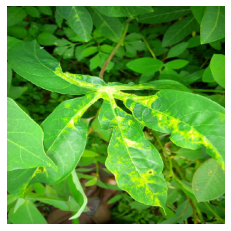

In [8]:
img_path = os.path.join(CFG.WORK_DIR, "train_images", train_labels.image_id[20])
img = image.load_img(img_path, target_size = (CFG.TARGET_SIZE, CFG.TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

# Modeling

In [9]:
model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [10]:
print('Our EfficientNet CNN has %d layers' %len(model.layers))

Our EfficientNet CNN has 239 layers


### Loading weights

In [11]:
model.load_weights('../input/cassava-leaf-disease-models/basic_EfNetB0_imagenet_512.h5')

### Training

In [12]:
model_save = ModelCheckpoint('./EffNetB0_512_8_best_weights.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = CFG.EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/5
2140/2139 [==============================] - ETA: 0s - loss: 0.6480 - acc: 0.7763
Epoch 00001: val_loss improved from inf to 0.82411, saving model to ./EffNetB0_512_8_best_weights.h5
2140/2139 [==============================] - 1600s 748ms/step - loss: 0.6480 - acc: 0.7763 - val_loss: 0.8241 - val_acc: 0.6357
Epoch 2/5
2140/2139 [==============================] - ETA: 0s - loss: 0.5221 - acc: 0.8231
Epoch 00002: val_loss improved from 0.82411 to 0.56936, saving model to ./EffNetB0_512_8_best_weights.h5
2140/2139 [==============================] - 1521s 711ms/step - loss: 0.5221 - acc: 0.8231 - val_loss: 0.5694 - val_acc: 0.7997
Epoch 3/5
2140/2139 [==============================] - ETA: 0s - loss: 0.4894 - acc: 0.8316
Epoch 00003: val_loss did not improve from 0.56936
2140/2139 [==============================] - 1563s 730ms/step - loss: 0.4894 - acc: 0.8316 - val_loss: 0.6439 - val_acc: 0.7848
Epoch 4/5
2140/2139 [==============================] - ETA: 0s - loss: 0.4612 - acc

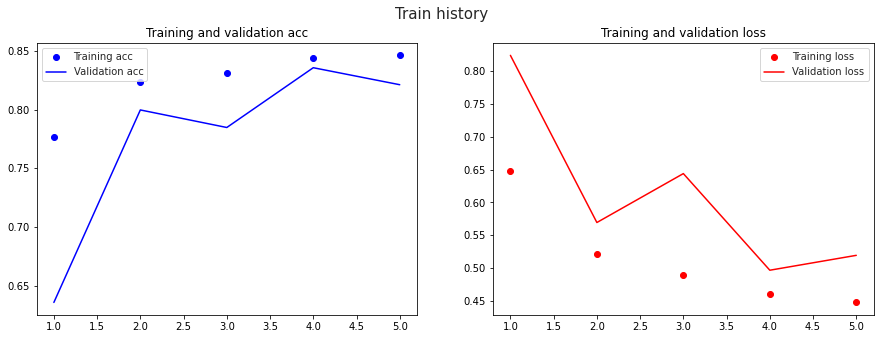

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [14]:
model.save('./EffNetB0_512_8.h5')

# Visualization of CNN intermediate activations

### Visualization of the first layer

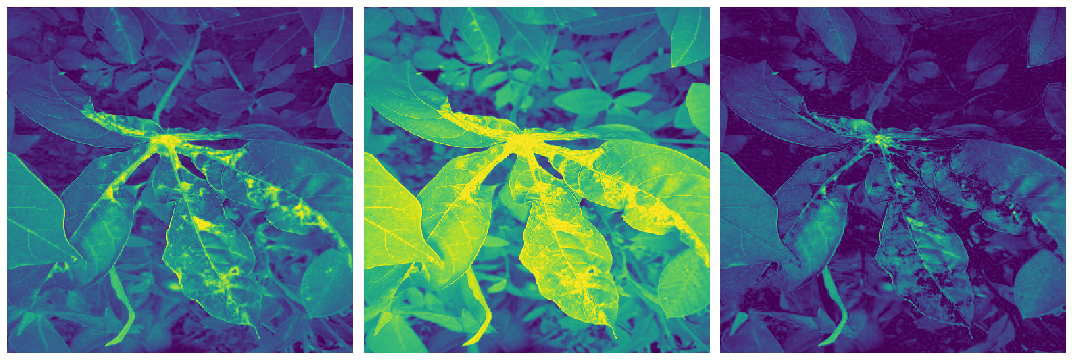

In [15]:
activation_layer_vis(img_tensor, 0)

### Visualization of the first 5 layers

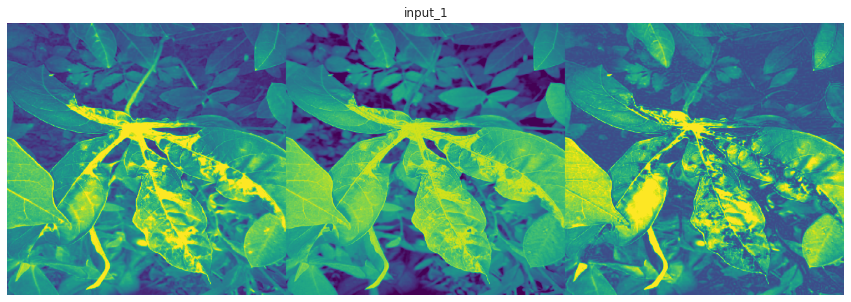

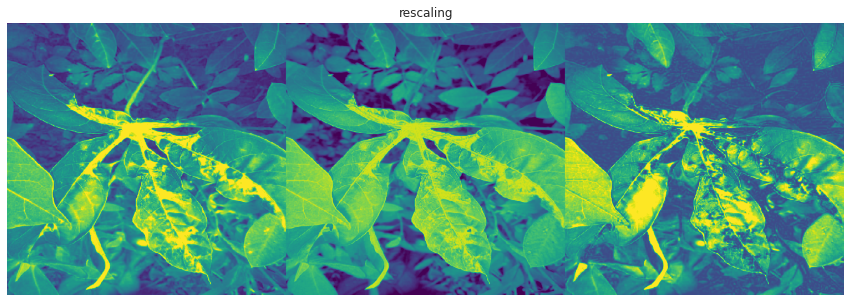

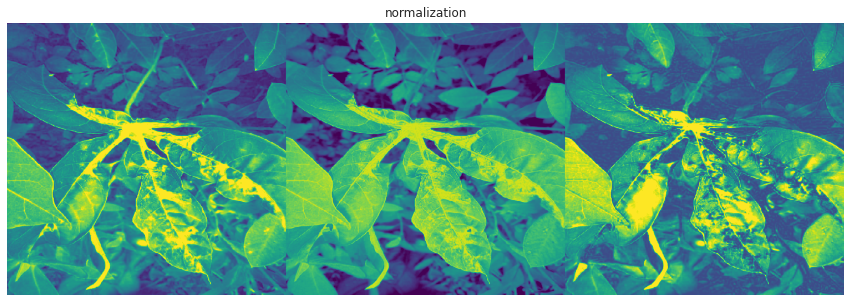

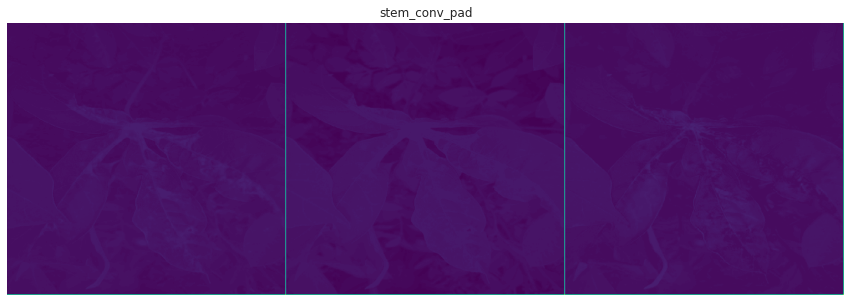

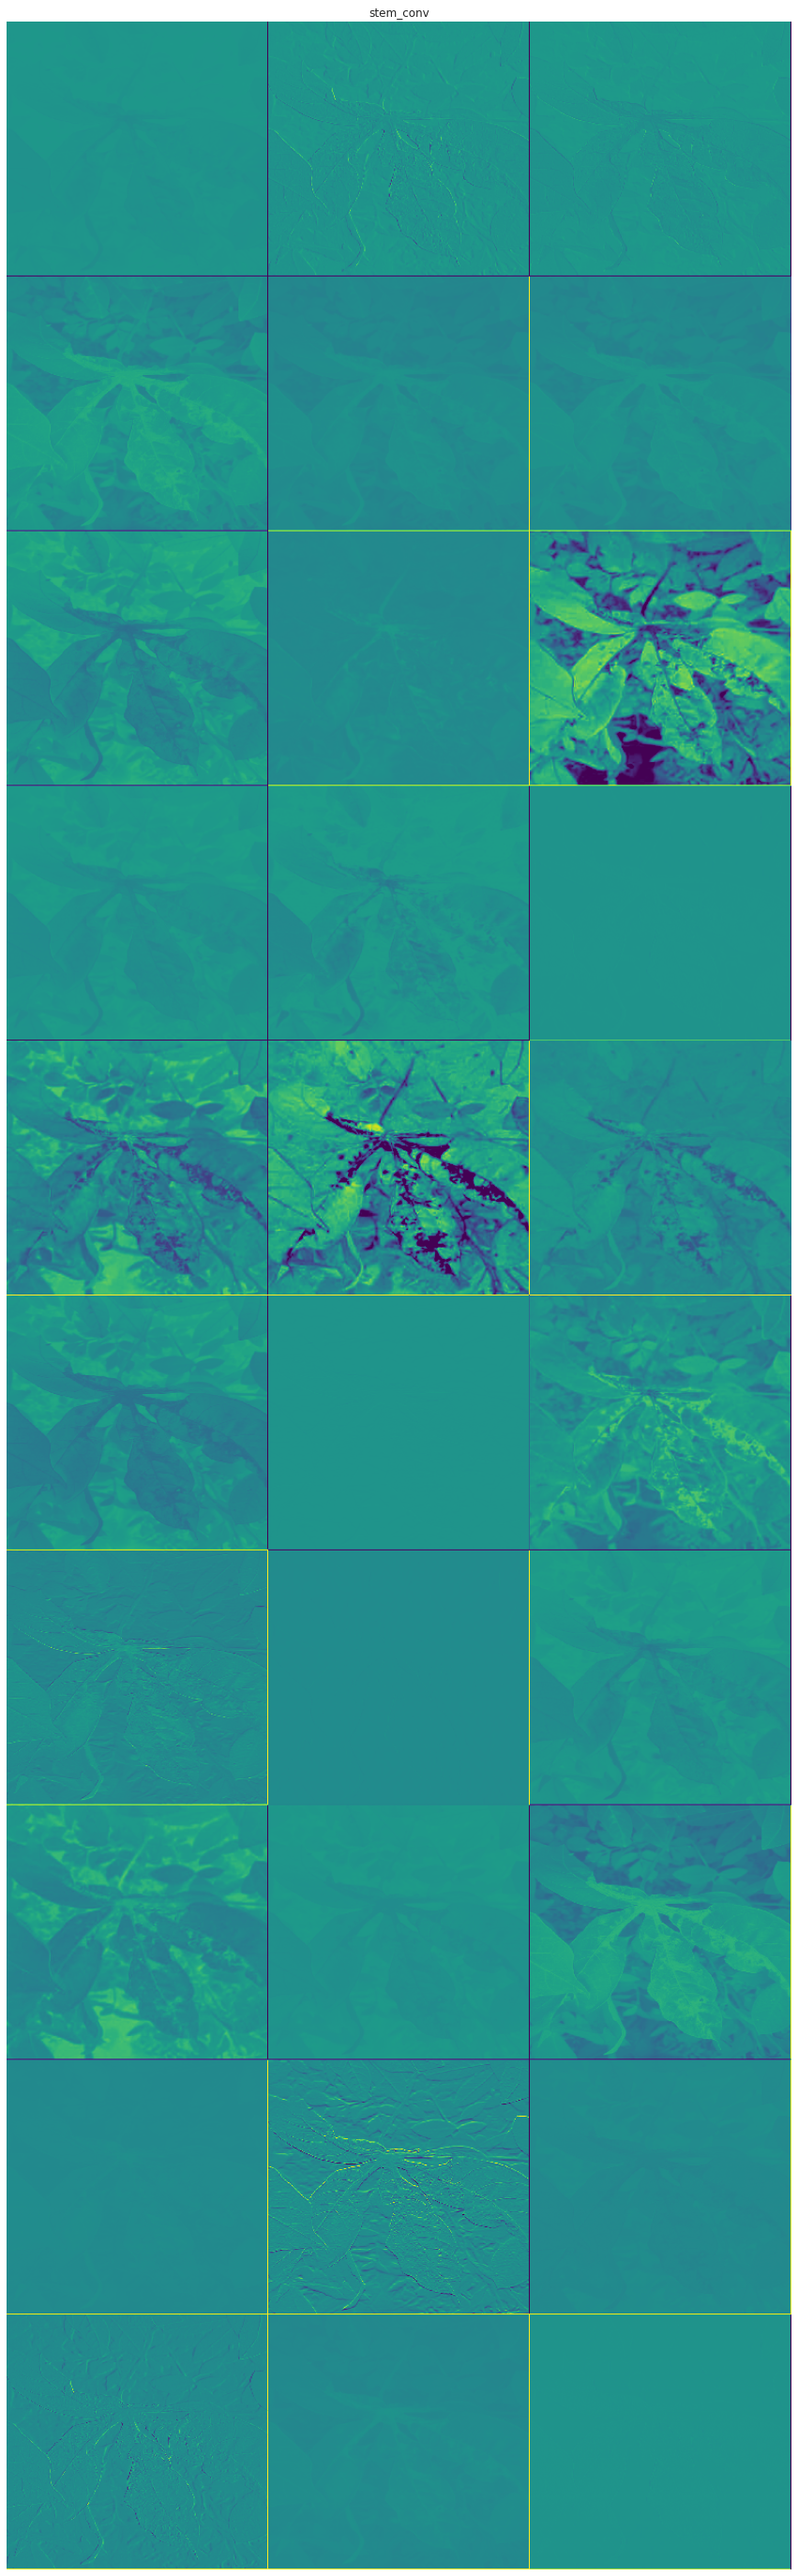

In [16]:
all_activations_vis(img_tensor, 5)

Visualization of intermediate activations gives a rough step-by-step understanding of how CNN works.

# Prediction

In [17]:
ss = pd.read_csv(os.path.join(CFG.WORK_DIR, "sample_submission.csv"))

In [18]:
preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(CFG.WORK_DIR,  "test_images", image_id))
    image = image.resize((CFG.TARGET_SIZE, CFG.TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

ss['label'] = preds
ss

image_id  label
0  2216849948.jpg      4

In [19]:
ss.to_csv('submission.csv', index = False)